In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import feature_handler as fn
from keract import get_activations, display_activations

In [2]:
## read all data
path = "./data/" 
TAIEX_df = pd.read_csv(path+'TXF.csv')
columns = ['Date','Open','High','Low','Close','Volume'] 
TAIEX_df.columns = columns
df = TAIEX_df[::-1].reset_index(drop=True)
price_df = df.drop(['Date', 'Volume'],axis=1)

## CNN training : 
- 取開高收低的sliding windows，並進行CNN的訓練
- 模型使用 2D CNN 中間包含`flatten`與`Dense`層
- 從`Dense`層取出輸出，將輸出進行K-means得分群
- 分別取長天期(30天)與短天期(8天)，從而得到兩種價格分群資訊

In [44]:
day = 30
long_list = fn.get_series_data(price_df , day , False)
print(long_list.shape)

ret = fn.triple_barrier(TAIEX_df.Close, 1.04 ,0.97, 20)
long_label = ret.triple_barrier_signal[day-1:len(ret)]
print('count:' ,long_label.value_counts())
long_label = long_label[::-1].reset_index(drop=True)

(2903, 30, 4)
count:  0    1115
-1     998
 1     790
Name: triple_barrier_signal, dtype: int64


In [45]:
## CNN Training
model = fn.cnn_training(long_list,long_label , day , 0.3 , 40)

## 取得CNN 最後一層的output
flatten_list = []
for periodData in long_list :
    keract_inputs = periodData.reshape(1 , long_list.shape[1], long_list.shape[2],1)
    activations = get_activations(model, keract_inputs)
    flatten_list.append(activations['flatten'])

## 分群
long_cluster_label = pd.Series(fn.get_cluster(flatten_list, 3))

Epoch 1/40
64/64 [==============================] - 1s 11ms/step - loss: 1.0041 - accuracy: 0.4882 - val_loss: 1.1577 - val_accuracy: 0.3651
Epoch 2/40
64/64 [==============================] - 1s 10ms/step - loss: 0.9630 - accuracy: 0.5098 - val_loss: 1.1883 - val_accuracy: 0.3054
Epoch 3/40
64/64 [==============================] - 1s 10ms/step - loss: 0.9518 - accuracy: 0.5281 - val_loss: 1.2521 - val_accuracy: 0.3272
Epoch 4/40
64/64 [==============================] - 1s 10ms/step - loss: 0.9358 - accuracy: 0.5226 - val_loss: 1.3433 - val_accuracy: 0.3284
Epoch 5/40
64/64 [==============================] - 1s 9ms/step - loss: 0.9247 - accuracy: 0.5394 - val_loss: 1.2614 - val_accuracy: 0.3456
Epoch 6/40
64/64 [==============================] - 1s 9ms/step - loss: 0.9137 - accuracy: 0.5492 - val_loss: 1.3145 - val_accuracy: 0.3410
Epoch 7/40
64/64 [==============================] - 1s 10ms/step - loss: 0.8960 - accuracy: 0.5699 - val_loss: 1.2755 - val_accuracy: 0.3571
Epoch 8/40
64/6

In [46]:
long_cluster_label.value_counts()

0    2316
2     526
1      61
dtype: int64

In [47]:
## 短天期，過程與上面相同
day = 8
short_list = fn.get_series_data(price_df , day , True)
print(short_list.shape)

##　短天期使用短label
ret = fn.triple_barrier(TAIEX_df.Close, 1.01 ,0.99, 5)
short_label = ret.triple_barrier_signal[day-1:len(ret)]
print('count:' ,short_label.value_counts())
short_label = short_label[::-1].reset_index(drop=True)

(2925, 8, 4)
count:  1    1275
-1    1073
 0     577
Name: triple_barrier_signal, dtype: int64


In [48]:
## CNN Training
model = fn.cnn_training(short_list,short_label , day , 0.3 , 20)

## 取得CNN 最後一層的output
flatten_list = []
for periodData in short_list :
    keract_inputs = periodData.reshape(1 , short_list.shape[1], short_list.shape[2],1)
    activations = get_activations(model, keract_inputs)
    flatten_list.append(activations['flatten'])

short_cluster_label = pd.Series(fn.get_cluster(flatten_list, 6))
print (len(short_cluster_label), short_cluster_label.value_counts())

Epoch 1/20
64/64 [==============================] - 1s 7ms/step - loss: 1.0646 - accuracy: 0.3986 - val_loss: 1.0838 - val_accuracy: 0.3497
Epoch 2/20
64/64 [==============================] - 0s 6ms/step - loss: 1.0496 - accuracy: 0.4162 - val_loss: 1.0660 - val_accuracy: 0.3497
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 1.0454 - accuracy: 0.4275 - val_loss: 1.0811 - val_accuracy: 0.3497
Epoch 4/20
64/64 [==============================] - 0s 5ms/step - loss: 1.0407 - accuracy: 0.4231 - val_loss: 1.0397 - val_accuracy: 0.4932
Epoch 5/20
64/64 [==============================] - 0s 5ms/step - loss: 1.0349 - accuracy: 0.4201 - val_loss: 1.0557 - val_accuracy: 0.3576
Epoch 6/20
64/64 [==============================] - 0s 5ms/step - loss: 1.0373 - accuracy: 0.4353 - val_loss: 1.0402 - val_accuracy: 0.4055
Epoch 7/20
64/64 [==============================] - 0s 5ms/step - loss: 1.0297 - accuracy: 0.4485 - val_loss: 1.0320 - val_accuracy: 0.4191
Epoch 8/20
64/64 [==

In [49]:
## 讓短天期與長天期等長
short_cluster_label = short_cluster_label[:len(long_cluster_label)]

In [50]:
short_cluster_label

0       5
1       5
2       5
3       4
4       4
       ..
2898    5
2899    2
2900    2
2901    1
2902    1
Length: 2903, dtype: int32

In [51]:
# 讀取其他指標的資料

TAIEX_Index = pd.read_csv(path+'TXF_Index.csv')
X = TAIEX_Index[::-1].reset_index(drop=True)[:len(short_cluster_label)]

In [52]:
Y = pd.DataFrame()
Y['long'] = long_label
Y['short'] = short_label[:len(long_label)]

In [53]:
long_label

0       0
1       0
2       0
3       0
4       0
       ..
2898    1
2899    1
2900    1
2901    1
2902    1
Name: triple_barrier_signal, Length: 2903, dtype: int64

## training feature : train with all feature
- several index and time serises price data
---
## XGBoost

In [54]:
## 將天期分群加入指標 DataFrame
X['long_cluster'] = long_cluster_label
X['short_cluster'] = short_cluster_label

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn import svm

In [56]:
label_ = ['long' , 'short']
predict_ = pd.DataFrame()
train_predict_ = pd.DataFrame()
isFirst = True
for label in label_ :
    test_ratio = 0.3
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    #ros = RandomOverSampler(random_state = 40)

    #X_train, y_train = ros.fit_resample(X_train, y_train)

    xgbc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                  colsample_bynode=1, colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                  importance_type='gain',learning_rate=0.1, max_delta_step=0, max_depth=3,
                  min_child_weight=1, monotone_constraints='()',
                  n_estimators=200, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                  random_state=27, reg_alpha=0, reg_lambda=1,
                  seed=27, subsample=1, tree_method='exact',
                  validate_parameters=1, verbosity=None)
    
    xgbc.fit(X_train,y_train)
    y_test_predp = xgbc.predict(X_test)
    y_train_predp = xgbc.predict(X_train)
    precision, recall, f1, _ = score(y_test, y_test_predp)
    print ( "precision(-1, 0, 1):" ,precision )    
    print ( "recall score(-1, 0, 1):" ,recall )
    
    if isFirst :
        predict_['date'] = testp.date
        train_predict_['date'] = trainp.date
        isFirst = False
    train_predict_[label] = y_train_predp
    predict_[label] = y_test_predp

label :  long
test date start form  2021/11/30 to 2018/5/15


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.40909091 0.32913386 0.58333333]
recall score(-1, 0, 1): [0.24573379 0.80076628 0.11041009]
label :  short
test date start form  2021/11/30 to 2018/5/15


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.39655172 0.24731183 0.52911392]
recall score(-1, 0, 1): [0.37581699 0.33576642 0.48831776]


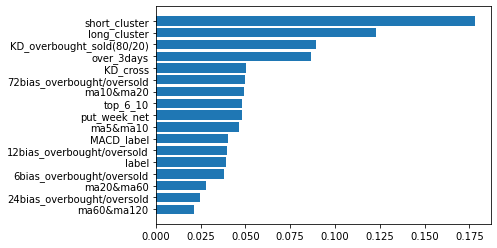

In [57]:
# feature important plot
from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(xgbc.feature_importances_, X_train.columns)

In [58]:
train_predict_.to_csv('./result/XGBoost_train.csv',index=False, encoding='utf-8')
predict_.to_csv('./result/XGBoost.csv',index=False, encoding='utf-8')

---
## SVM

In [59]:
label_ = ['long' , 'short']
cluster = [0,1,2]
predict_ = pd.DataFrame()
train_predict_ = pd.DataFrame()
isFirst = True
for label in label_ :
    test_ratio = 0.3
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
    #ros = RandomOverSampler(random_state = 40)

    #X_train, y_train = ros.fit_resample(X_train, y_train)

    clf=svm.SVC(kernel='linear',C=1,gamma='auto',degree=3)
    
    clf.fit(X_train,y_train)
    y_test_predp = clf.predict(X_test)
    y_train_predp = clf.predict(X_train)
    precision, recall, f1, _ = score(y_test, y_test_predp)
    print ( "precision(-1, 0, 1):" ,precision )
    print ( "recall score(-1, 0, 1):" ,recall )
    
    if isFirst :
        predict_['date'] = testp.date
        train_predict_['date'] = trainp.date
        isFirst = False
    train_predict_[label] = y_train_predp
    predict_[label] = y_test_predp

label :  long
test date start form  2021/11/30 to 2018/5/15
precision(-1, 0, 1): [0.27586207 0.3164557  0.51960784]
recall score(-1, 0, 1): [0.05460751 0.86206897 0.16719243]
label :  short
test date start form  2021/11/30 to 2018/5/15
precision(-1, 0, 1): [0.34355828 0.23668639 0.54521277]
recall score(-1, 0, 1): [0.36601307 0.2919708  0.47897196]


In [60]:
train_predict_.to_csv('./result/Svm_train.csv',index=False, encoding='utf-8')
predict_.to_csv('./result/Svm.csv',index=False, encoding='utf-8')

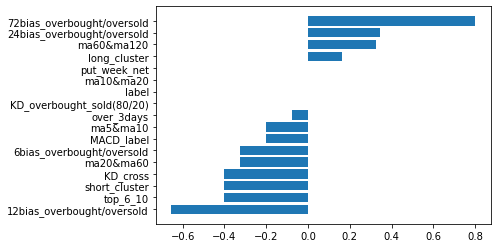

In [61]:
# feature important plot
from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(clf.coef_[1], X_train.columns)

## training feature : by each cluster
- several index and time serises price data
---
## XGBoost

In [62]:
label_ = ['long' , 'short']
cluster_ = [0,1,2]
predict_ = pd.DataFrame()
isFirst = True
for cluster in cluster_ :
    print ('cluster : ' , cluster)
    for label in label_ :
        test_ratio = 0.4
        trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        testp = X [ : math.ceil(len(X)*test_ratio)]
        print("label : ", label )
        print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

        X_train = trainp.drop(['date'],axis = 1).reset_index(drop = True)
        y_train = Y[label][math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        
        
        X_test = testp.drop(['date'],axis = 1).reset_index(drop = True)
        y_test = Y[label] [ : math.ceil(len(X)*test_ratio)].reset_index(drop = True)
        
        X_train_cluster = X_train[X_train.long_cluster==cluster]
        y_train_cluster = y_train[X_train.long_cluster==cluster]
        
        
        X_test_cluster =  X_test[X_test.long_cluster==cluster]
        y_test_cluster = y_test[X_test.long_cluster==cluster]

        #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
        #ros = RandomOverSampler(random_state = 40)

        #X_train, y_train = ros.fit_resample(X_train, y_train)

        xgbc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                      colsample_bynode=1, colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                      importance_type='gain',learning_rate=0.1, max_delta_step=0, max_depth=2,
                      min_child_weight=1, monotone_constraints='()',
                      n_estimators=200, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                      random_state=27, reg_alpha=0, reg_lambda=1,
                      seed=27, subsample=1, tree_method='exact',
                      validate_parameters=1,  verbosity = 0)

        xgbc.fit(X_train_cluster,y_train_cluster)
        y_test_predp = xgbc.predict(X_test_cluster)

        precision, recall, f1, _ = score(y_test_cluster, y_test_predp)
        print ( "precision(-1, 0, 1):" ,precision )
        print ( "recall score(-1, 0, 1):" ,recall )
#         if isFirst :
#             predict_['date'] = testp.date
#             isFirst = False
#         predict_[label] = y_test_predp

cluster :  0
label :  long
test date start form  2021/11/30 to 2017/3/9


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.32822086 0.42276423 0.32      ]
recall score(-1, 0, 1): [0.35785953 0.65491184 0.02962963]
label :  short
test date start form  2021/11/30 to 2017/3/9


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


precision(-1, 0, 1): [0.38461538 0.35714286 0.48096192]
recall score(-1, 0, 1): [0.34954407 0.27777778 0.57007126]
cluster :  1
label :  long
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.25       0.         0.83333333]
recall score(-1, 0, 1): [0.71428571 0.         0.43478261]
label :  short
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.28571429 0.         0.72      ]
recall score(-1, 0, 1): [0.25      0.        0.7826087]
cluster :  2
label :  long
test date start form  2021/11/30 to 2017/3/9


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass opt

precision(-1, 0, 1): [0.31958763 0.125      0.45762712]
recall score(-1, 0, 1): [0.75609756 0.01694915 0.421875  ]
label :  short
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.30769231 0.         0.65714286]
recall score(-1, 0, 1): [0.62222222 0.         0.49462366]


C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [63]:
label_ = ['long' , 'short']
cluster_ = [0,1,2]
predict_ = pd.DataFrame()
isFirst = True
for cluster in cluster_ :
    print ('cluster : ' , cluster)
    for label in label_ :
        test_ratio = 0.4
        trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        testp = X [ : math.ceil(len(X)*test_ratio)]
        print("label : ", label )
        print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

        X_train = trainp.drop(['date'],axis = 1).reset_index(drop = True)
        y_train = Y[label][math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
        
        
        X_test = testp.drop(['date'],axis = 1).reset_index(drop = True)
        y_test = Y[label] [ : math.ceil(len(X)*test_ratio)].reset_index(drop = True)
        
        X_train_cluster = X_train[X_train.long_cluster==cluster]
        y_train_cluster = y_train[X_train.long_cluster==cluster]
        
        
        X_test_cluster =  X_test[X_test.long_cluster==cluster]
        y_test_cluster = y_test[X_test.long_cluster==cluster]

        #X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
        #ros = RandomOverSampler(random_state = 40)

        #X_train, y_train = ros.fit_resample(X_train, y_train)

        clf=svm.SVC(kernel='linear',C=2,gamma='auto')

        clf.fit(X_train_cluster,y_train_cluster)
        y_test_predp = clf.predict(X_test_cluster)

        precision, recall, f1, _ = score(y_test_cluster, y_test_predp)
        print ( "precision(-1, 0, 1):" ,precision )
        print ( "recall score(-1, 0, 1):" ,recall )

#         if isFirst :
#             predict_['date'] = testp.date
#             isFirst = False
#         predict_[label] = y_test_predp

cluster :  0
label :  long
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.33222591 0.4126506  1.        ]
recall score(-1, 0, 1): [0.33444816 0.69017632 0.0037037 ]
label :  short
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.37037037 0.32642487 0.47884187]
recall score(-1, 0, 1): [0.36474164 0.29166667 0.51068884]
cluster :  1
label :  long
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.19047619 0.         0.72727273]
recall score(-1, 0, 1): [0.57142857 0.         0.34782609]
label :  short
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.09090909 0.         0.61904762]
recall score(-1, 0, 1): [0.125      0.         0.56521739]
cluster :  2
label :  long
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.28571429 0.         0.36585366]
recall score(-1, 0, 1): [0.82926829 0.         0.234375  ]
label :  short
test date start form  2021/11/30 to 2017/3/9
precision(-1, 0, 1): [0.26530

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


def get_cnn_series_data( df, period) -> list:
    list_ = []
    for i in range(len(df)-period+1):
        list_.append(df[i:i+period].values)
        
    return np.array(list_)

def cnn_training(allData, allLabel, day , splitsize, epoches = 100) :

    week_list = allData
    week_label = allLabel
    # 定義梯度下降批量
    batch_size = 32
    # 定義分類數量
    num_classes = 3
    # 定義訓練週期
    epochs = epoches

    # 定義圖像寬、高
    img_rows, img_cols = day, 17
    input_shape = ( img_rows, img_cols)

    # 載入 MNIST 訓練資料
    split_ratio = splitsize
    x_train = week_list[ math.ceil(len(week_list)*split_ratio) :]
    x_test = week_list[ : math.ceil(len(week_list)*split_ratio) ]

    y_train = week_label[ math.ceil(len(week_label)*split_ratio) :]
    y_test = week_label[ : math.ceil(len(week_label)*split_ratio) ]

    x_train = x_train.reshape(x_train.shape[0] , img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols ,1)

    # x_train  = torch.from_numpy(x_train)
    # x_test  = torch.from_numpy(x_test)

    # y_train = torch.from_numpy(y_train)
    # y_test = torch.from_numpy(y_test)

    input_shape = (img_rows, img_cols,1 )

    # 保留原始資料，供 cross tab function 使用
    y_test_org = y_test


    # y 值轉成 one-hot encoding
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)

    # 建立簡單的線性執行的模型
    model = Sequential()
    # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(16, kernel_size=(3,10),
                    activation='relu',
                    input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(GaussianNoise(0.5))
    # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
    model.add(Conv2D(32, (3,2), activation='relu'))
    # 建立池化層，池化大小=2x2，取最大值
    model.add(MaxPooling2D(pool_size=(3, 5)))
    # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
    model.add(Dropout(0.25))
    # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
    model.add(Flatten( name ='flatten'))
    # 全連接層: 128個output
    model.add(Dense(batch_size, 'sigmoid', name ='Dense'))
    # 使用 softmax activation function，將結果分類
    model.add(Dense(num_classes, activation='softmax' ))

    # 編譯: 選擇損失函數、優化方法及成效衡量方式
    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])

    # 進行訓練, 訓練過程會存在 train_history 變數中
    train_history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))

    # 顯示損失函數、訓練成果(分數)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score)
    print('Test accuracy:', score)
    return model

day = 10
X_cnn = get_cnn_series_data(X.drop(['date'],axis=1),day)

cnn_training(X_cnn , short_label[:len(X_cnn)], day , 0.3 , 100)


X_cnn.shape